# Laboratory 05 - Graph analytics with GraphFrames

In [ ]:
!pip3 install graphviz

In [2]:
from graphframes import GraphFrame

## 1 - Input data

In [3]:
airports_path = '/data/students/bigdata_internet/lab5/airports.csv'
airlines_path = '/data/students/bigdata_internet/lab5/airlines.csv'
routes_path = '/data/students/bigdata_internet/lab5/routes.csv' 

In [4]:
airports_DF = spark.read.load(airports_path, \
                        format='csv', \
                        header=True, \
                        inferSchema=True)
airlines_DF = spark.read.load(airlines_path, \
                        format='csv', \
                        header=True, \
                        inferSchema=True)
routes_DF = spark.read.load(routes_path, \
                        format='csv', \
                        header=True, \
                        inferSchema=True)

## 2 - Top airports and airlines

### 2.1 - Countries with more than 200 airports

Reported in ascending order.

In [5]:
# 
n_airports_DF = airports_DF.select('country', 'id').groupBy('country')\
            .agg({'id':'count'}).filter('count(id) > 200')\
            .sort('count(id)', ascending=True)
n_airports_DF.show(10)
n_moreThan200 = n_airports_DF.count()
print(f"The number of countries having more than 200 airports is: {n_moreThan200}")

+-------------+---------+
|      country|count(id)|
+-------------+---------+
|       France|      217|
|        China|      241|
|      Germany|      249|
|       Russia|      264|
|       Brazil|      264|
|    Australia|      334|
|       Canada|      430|
|United States|     1512|
+-------------+---------+



[Stage 11:====================================================> (194 + 1) / 200]

The number of countries having more than 200 airports is: 8


### 2.2 - Top 5 countries with the highest airports (in terms of altitude)

In [6]:
# UDF for transforming altitude form feet to meters
spark.udf.register('ft2m', lambda h: float(round(h/3.281, 3)))

<function __main__.<lambda>(h)>

In [7]:
# For getting airport names at the end
airports_alt_name_DF = airports_DF\
                .selectExpr('ft2m(altitude) AS max_altitude_m', 'name')
tmp_DF = airports_DF.selectExpr('country', 'name', \
                                'ft2m(altitude) AS altitude_m')

# Find max altitude per country (groupBy + aggregate)
# Get name of highest per country with join (on `airports_alt_name_DF`)
ord2_DF = tmp_DF.withColumn('altitude_m', tmp_DF.altitude_m.cast('float'))\
                .groupBy('country').agg({'altitude_m':'max'})\
                .withColumnRenamed('max(altitude_m)', 'max_altitude_m')\
                .join(airports_alt_name_DF, 'max_altitude_m')\
                .sort('max_altitude_m', ascending=False)
ord2_DF.show(5, truncate=False)

[Stage 16:>                                                         (0 + 1) / 1]

+--------------+---------+--------------------------------------+
|max_altitude_m|country  |name                                  |
+--------------+---------+--------------------------------------+
|4410.85       |China    |Daocheng Yading Airport               |
|4070.405      |Bolivia  |El Alto International Airport         |
|3825.663      |Peru     |Inca Manco Capac International Airport|
|3779.336      |Nepal    |Syangboche Airport                    |
|3478.817      |Argentina|La Quiaca Airport                     |
+--------------+---------+--------------------------------------+
only showing top 5 rows



### 2.3 - Top 10 routes in the world

In [8]:
routes_DF.createOrReplaceTempView('routes_tab')
# Count the number of routes having same src and dst
topRoutes_DF = spark.sql(
    """SELECT airport_source_id, airport_destination_id, count(*)
    FROM routes_tab
    GROUP BY airport_source_id, airport_destination_id
    ORDER BY `count(1)` DESC
    """)

In [9]:
# Merge with airports to include names
airports_src_DF = airports_DF\
  .selectExpr('id AS airport_source_id', 'name AS name_src', 'city AS city_src')
airports_dst_DF = airports_DF\
  .selectExpr('id AS airport_destination_id', 'name AS name_dst', 'city AS city_dst')
top_routes_DF_withNames = topRoutes_DF.join(airports_src_DF, 'airport_source_id')\
    .join(airports_dst_DF, 'airport_destination_id')\
    .withColumnRenamed('count(1)', 'n_flights')\
    .select('n_flights', 'name_src', 'city_src', 'name_dst', 'city_dst')\
    .sort('n_flights', ascending=False)
top_routes_DF_withNames.show(10, truncate=False)

[Stage 22:====================================================> (196 + 1) / 200]

+---------+------------------------------------------------+---------+-------------------------------------------------+-----------+
|n_flights|name_src                                        |city_src |name_dst                                         |city_dst   |
+---------+------------------------------------------------+---------+-------------------------------------------------+-----------+
|20       |Chicago O'Hare International Airport            |Chicago  |Hartsfield Jackson Atlanta International Airport |Atlanta    |
|19       |Hartsfield Jackson Atlanta International Airport|Atlanta  |Chicago O'Hare International Airport             |Chicago    |
|13       |Chicago O'Hare International Airport            |Chicago  |Louis Armstrong New Orleans International Airport|New Orleans|
|13       |Phuket International Airport                    |Phuket   |Suvarnabhumi Airport                             |Bangkok    |
|12       |Abu Dhabi International Airport                 |Abu Dhabi

## 3 - Create graph of flight connections


### 3.1 - Filter out rows with missing values (`\\\\N`)

In [10]:
# Remove invalid entries
filtered_routes_DF = spark.sql("""SELECT * 
        FROM routes_tab 
        WHERE NOT airport_source_id = '\\\\N' 
            AND NOT airport_destination_id = '\\\\N' """)

print(f"The number of invalid routes is {routes_DF.count() - filtered_routes_DF.count()}")

The number of invalid routes is 423


In [11]:
# Create Graph
# Need to cast the integer values to strings
airports_DF = airports_DF.withColumn('id', airports_DF.id.cast('string'))\
# Cast IDs and rename columns (src, dst)
filt_routes_DF = filtered_routes_DF\
    .withColumn('airport_source_id', \
                filtered_routes_DF.airport_source_id.cast('string'))\
    .withColumn('airport_destination_id', \
                filtered_routes_DF.airport_destination_id.cast('string'))\
    .withColumnRenamed('airport_source_id', 'src')\
    .withColumnRenamed('airport_destination_id', 'dst')

In [12]:
# Create GraphFrame
g = GraphFrame(airports_DF, filt_routes_DF)

## 4 - Graph analysis and processing

### 4.1 - Top 5 airports with highest inDegree/outDegree ratio

I.e., airports which have a number of incoming flights much higher than outgoing ones.

In [13]:
in_deg = g.inDegrees
out_deg = g.outDegrees

In [14]:
vert_in_out_DF = g.vertices.join(in_deg, 'id').join(out_deg, 'id')

In [15]:
# Evaluate the inDegree/outDegree ratio
from pyspark.sql.types import FloatType
spark.udf.register('in_out_ratio',lambda in_d,out_d: in_d/out_d,FloatType())

<function __main__.<lambda>(in_d, out_d)>

In [16]:
vert_ratio_DF = vert_in_out_DF\
        .selectExpr('id', 'name', 'city', \
                    'in_out_ratio(inDegree, outDegree) AS ratio')\
        .sort('ratio', ascending=False)

vert_ratio_DF.show(5)

[Stage 32:===================================================>  (191 + 1) / 200]

+----+--------------------+----------+-----+
|  id|                name|      city|ratio|
+----+--------------------+----------+-----+
|3862|Portland Internat...|  Portland|  9.0|
| 653|       Banak Airport|   Lakselv|  3.0|
|5416|    Suavanao Airport|  Suavanao|  3.0|
|4285|      Yeager Airport|Charleston|  2.5|
|6289|   Longreach Airport| Longreach|  2.5|
+----+--------------------+----------+-----+
only showing top 5 rows



### 4.2 - Bari airport

In [17]:
# Airports which are at distance of 1 hop
df_1_hop = g.find("(a)-[]->(b)")

#### 4.2.1 - Airports from which one can reach Bari with 1 flight


In [18]:
n_one_to_Bari = df_1_hop.filter("b.city == 'Bari'").distinct().count()
print(f"Number of airports that can reach Bari with 1 flight: {n_one_to_Bari}")

23/01/25 09:20:40 WARN util.Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
[Stage 36:=====================================================>(198 + 2) / 200]

Number of airports that can reach Bari with 1 flight: 41


#### 4.2.2 - Airports that can be reached *from* Bari in 1 flight

In [19]:
n_one_from_Bari = df_1_hop.filter("a.city == 'Bari'").distinct().count()

print(f"Number of airports that can be reached with 1 flight from Bari: {n_one_from_Bari}")

[Stage 41:=====================================================>(199 + 1) / 200]

Number of airports that can be reached with 1 flight from Bari: 41


Check inDegree and outDegree for bari

In [20]:
vert_in_out_DF.filter("city == 'Bari'").select('city', 'inDegree', 'outDegree').show()

+----+--------+---------+
|city|inDegree|outDegree|
+----+--------+---------+
|Bari|      50|       50|
+----+--------+---------+



In this case, the number of airports which can reach Bari in 1 hop and airports that can be reached from Bari in 1 hop is 41, which is different from in/outDegree (both 50). This happens because there are flights which are performed by more than 1 airline, therefore when isolating airports after motif-finding, it is necessary to apply `distinct()` to remove the duplicates caused by this.
In any case, without applying `distinct()`, i.e., simply counting the number of elements reported by motif-finding, returns 50 in both cases.

### 4.3 - Number of airports that can be reached from Bari in 2 flights

In [21]:
df_2_hop = g.find("(a)-[]->(b); (b)-[]->(c)")

In [22]:
# Need to perform the 'distinct' operation as before
two_from_Bari_DF = df_2_hop.filter("a.city == 'Bari'").select("c.name").distinct()
n_two_from_Bari = two_from_Bari_DF.count()

print(f"Number of distinct airports that can be reached with 2 \
flights from Bari (including Bari itself): {n_two_from_Bari}")

[Stage 60:>                                                         (0 + 1) / 1]

Number of distinct airports that can be reached with 2 flights from Bari (including Bari itself): 507


### 4.4 - Los Angeles International Airport vs. Catania airport

In [23]:
# Get ID of Los Angeles International Airport
LA_DF = g.vertices.filter('name == "Los Angeles International Airport"')
LA_id = LA_DF.collect()[0].asDict()['id']
print(f"Los Angeles International ID: {LA_id}")

Los Angeles International ID: 3484


In [24]:
# Get ID of Catania airport
catania_row = g.vertices.filter('city == "Catania"').collect()[0].asDict()
catania_id = catania_row['id']
print(f"Catania airport ID: {catania_id}")

Catania airport ID: 1509


In [25]:
# Get shortest path from every node to Catania or Los Angeles
sp_DF = g.shortestPaths([str(LA_id), str(catania_id)])

In [26]:
# Extract the values from column 'distances'
# Need to remove rows with no elements ('null')
dist_DF = sp_DF\
    .select(f'distances.{LA_id}', f'distances.{catania_id}')\
    .withColumnRenamed(LA_id, 'd_LA')\
    .filter('d_LA IS NOT null')\
    .withColumnRenamed(catania_id, 'd_cat')\
    .filter('d_cat IS NOT null')
# d_LA contains the distance of each ariport from LA, 
# d_cat contains the dist. from Catania
dist_DF.count()

3169

#### 4.4.1/2/3

In [27]:
# Count
n_LA_less_Cat = dist_DF.filter('d_LA < d_cat').count()
n_Cat_less_LA = dist_DF.filter('d_LA > d_cat').count()
n_LA_same_Cat = dist_DF.filter('d_LA == d_cat').count()
print(f"N. of airports which can reach Catania with less steps: {n_Cat_less_LA}")
print(f"N. of airports which can reach LA with less steps: {n_LA_less_Cat}")
print(f"N. of airports which can reach both with the same n. of hops: {n_LA_same_Cat}")

[Stage 400:===========================================>         (166 + 6) / 200]

N. of airports which can reach Catania with less steps: 136
N. of airports which can reach LA with less steps: 1812
N. of airports which can reach both with the same n. of hops: 1221


### 4.5 - Number of connected components of at least 2 airports

In [28]:
# First, need to drop isolated vertices 
g_1 = g.dropIsolatedVertices()

In [29]:
sc.setCheckpointDir('hdfs:///user/s315054/lab05/gf_checkpoints')

In [30]:
# Find connected components
conn_comp_DF = g_1.connectedComponents()

In [31]:
# Count number of connected components (with more than 1 node)
conn_comp_corr_DF = conn_comp_DF.groupBy('component')\
                .agg({"*":"count"}).filter('count(1) > 1')
n_comp = conn_comp_corr_DF.select('component').distinct().count()
print(f"Number of connected components (subgraphs): {n_comp}")

Number of connected components (subgraphs): 7


### 4.6 - Flights performed by 2 different airlines - print graph

The subgraph of flights performed by 2 different airlines consists in the sets of 2 edges having the same source and detination and different airline IATA

In [32]:
# Can directly use the graph without isolated vertices...
diff_airlines_DF = g_1.find("(a)-[e1]->(b); (a)-[e2]->(b)")\
                .filter('e1.airline_iata != e2.airline_iata')

In [33]:
# Take ID1, city1, ID2, city2 and IATAs of airlines
smaller_diff_DF = diff_airlines_DF.selectExpr('a.id AS id1', 'a.city AS city1',\
                            'b.id AS id2', 'b.city AS city2', \
                            'e1.airline_iata AS iata1', \
                            'e2.airline_iata AS iata2')

In [34]:
# Need to find airlines which have at least 6 cities
n_cities_airline_DF = smaller_diff_DF.select('city1', 'iata1')\
                .groupBy('iata1').agg({'city1':'approx_count_distinct'})\
                .withColumnRenamed('approx_count_distinct(city1)', 'n_cities')

In [35]:
# Take 2 airlines satisfying conditions
# (Prevent big graphs by setting the max.n. of cities to 10)
selected_airlines = n_cities_airline_DF.filter('n_cities>6 AND n_cities<10')\
                                           .collect()[1:3]

In [36]:
selected_iata = [str(selected_airlines[i]['iata1']) for i in range(len(selected_airlines))]
selected_subgraphs_DF = smaller_diff_DF.filter(f"iata1 == '{selected_iata[0]}' OR iata1 == '{selected_iata[1]}'")\
            .select('id1', 'city1', 'id2', 'city2', 'iata1').distinct()

# In this DF there are the src and dest ID and city of all flights made by 
# either of the 2 selected airlines, for which there exists (at least)
# another company doing the same flight

In [37]:
# Need to perform an outer join to take all cities appearing in either
# 'city1' or 'city2'

DF1 = selected_subgraphs_DF.selectExpr('id1 AS id', 'city1 AS city')
DF2 = selected_subgraphs_DF.selectExpr('id2 AS id', 'city2 AS city')
two_airlines_vertices = DF1.join(DF2, ['id', 'city'], 'outer').distinct()
two_airlines_vertices.count()

17

In [38]:
two_airlines_edges = selected_subgraphs_DF\
        .selectExpr('id1 as src', 'id2 AS dst', 'iata1 AS iata')

#### Plotting the graph of the selected airlines

In [39]:
from graphviz import Digraph

In [40]:
vertices_local = two_airlines_vertices.collect()
edges_local = two_airlines_edges.collect()
vert_dict_lst = [vertices_local[i].asDict() for i in range(len(vertices_local))]
edges_dict_lst = [edges_local[i].asDict() for i in range(len(edges_local))]

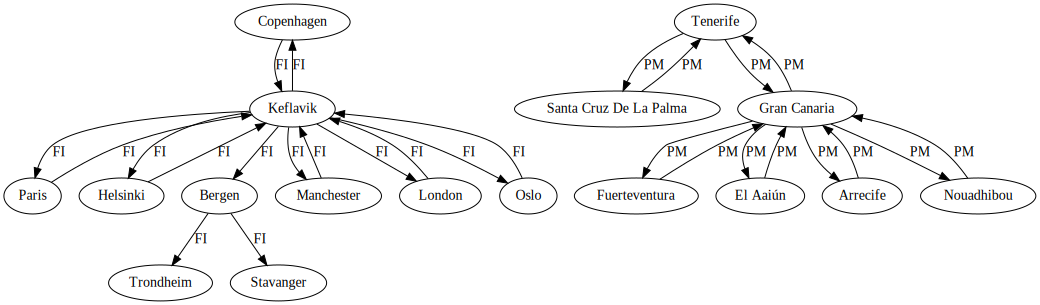

In [41]:
gr = Digraph()
for i in range(len(vert_dict_lst)):
    gr.node(vert_dict_lst[i]['id'], vert_dict_lst[i]['city'])
for i in range(len(edges_dict_lst)):
    gr.edge(edges_dict_lst[i]['src'], edges_dict_lst[i]['dst'], edges_dict_lst[i]['iata'])
    
gr

## 5 - Bonus Task

### 5.1 - Max distance from "Beijing Capital International Airport" in 2 flights

In [42]:
# Motif-finding for 2 hops from Beijing
beijing_name = "Beijing Capital International Airport"
# Take only the IDs to be able to perform the join 
g_bei_2 = g.find("(a)-[]->(b); (b)-[]->(c)")\
            .filter(f"a.name == '{beijing_name}'")\
            .filter(f"c.name != '{beijing_name}'")\
            .distinct().selectExpr("a.id AS id_a",\
                                "b.id AS id_b",\
                                "c.id AS id_c")

In [43]:
# Beijing coordinates
beijing_airport_DF = airports_DF.filter(f"name == '{beijing_name}'")
beijing_local = beijing_airport_DF.collect()[0].asDict()
beijing_lat = float(beijing_local['latitude'])
beijing_long = float(beijing_local['longitude'])

In [44]:
# HAVERSINE FORMULA - UDF (from lab 03)
import numpy as np

def distBeijing(coords1, coords2):
    lat1 = float(coords1[0]) * (np.pi/180)
    lon1 = float(coords1[1]) * (np.pi/180)
    lat2 = float(coords2[0]) * (np.pi/180)
    lon2 = float(coords2[1]) * (np.pi/180)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat/2.0)**2+np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return float(km)  ### NOTE: the returned distance is already in km!

spark.udf.register("distBeijing", distBeijing)

<function __main__.distBeijing(coords1, coords2)>

In [45]:
# Include in the DF the coordinates of each airport
airport_0 = airports_DF.selectExpr('id AS id_a','latitude AS lat_a',\
                                   'longitude AS long_a')
airport_1 = airports_DF.selectExpr('id AS id_b','latitude AS lat_b',\
                                   'longitude AS long_b')
airport_2 = airports_DF.selectExpr('id AS id_c','latitude AS lat_c',\
                                   'longitude AS long_c')

g_2_with_coordinates_DF = g_bei_2.join(airport_0, 'id_a')\
                            .join(airport_1, 'id_b')\
                            .join(airport_2, 'id_c')

In [48]:
# Apply the UDF and get the distances:
distances_DF = g_2_with_coordinates_DF\
        .selectExpr("""distBeijing((lat_a, long_a), (lat_b, long_b))
            + distBeijing((lat_b, long_b), (lat_c, long_c)) AS tot_dist""")\
        .sort("tot_dist", ascending=False)
distances_DF.head().asDict()    # Get 1st element of ordered DF

{'tot_dist': 25274.68083107938}